In [ ]:
# !unzip -q "dataset.zip"
! git clone https://github.com/nithiroj/Fall-Detection-PyTorch

Cloning into 'Fall-Detection-PyTorch'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 12 (delta 1), reused 12 (delta 1), pack-reused 0
Unpacking objects: 100% (12/12), done.


In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
!unzip -q "/content/Fall-Detection-PyTorch/dataset.zip"

In [ ]:
!wget http://fenix.univ.rzeszow.pl/~mkepski/ds/data/adl-37-cam0-rgb.zip

--2021-06-30 14:23:03--  http://fenix.univ.rzeszow.pl/~mkepski/ds/data/adl-37-cam0-rgb.zip
Resolving fenix.univ.rzeszow.pl (fenix.univ.rzeszow.pl)... 62.93.43.105
Connecting to fenix.univ.rzeszow.pl (fenix.univ.rzeszow.pl)|62.93.43.105|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 108338063 (103M) [application/zip]
Saving to: ‘adl-37-cam0-rgb.zip’

adl-37-cam0-rgb.zip 100%[===================>] 103.32M  15.2MB/s    in 7.9s    

2021-06-30 14:23:11 (13.0 MB/s) - ‘adl-37-cam0-rgb.zip’ saved [108338063/108338063]



In [ ]:
!unzip -q "/content/adl-37-cam0-rgb.zip"

In [ ]:
root = '/content'

import os
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import argparse
import numpy as np

import cv2


import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models, datasets, transforms
from PIL import Image

%matplotlib inline

# Create Dataset

In [ ]:
data_dir = f'{root}/dataset'
batch_size = 32

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(), # convert 1 to 3 channels
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Train dataset and dataloader
train_dataset = datasets.ImageFolder(f'{data_dir}/train', transform=transform)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

train_sizes = len(train_dataset)
class_names = train_dataset.classes

# Validation dataset and dataloader
val_dataset = datasets.ImageFolder(f'{data_dir}/val', transform)

val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)

val_sizes = len(val_dataset)

In [ ]:
class_names

['fall', 'not_fall']

<function vars>

In [ ]:
train_sizes, val_sizes

(11173, 3310)

In [ ]:
len(train_dataset)

11173

In [ ]:
train_dataset[0][0].shape

torch.Size([3, 224, 224])

# Create Model

In [ ]:
class FDNet(nn.Module):
    def __init__(self, out_features=2):
        super(FDNet, self).__init__()
        mnet = models.mobilenet_v2(pretrained=True)
        for name, param in mnet.named_parameters():
            if("bn" not in name):
                param.requires_grad_(False)
            
        # Parameters of newly constructed modules have requires_grad=True by default
        in_features = mnet.classifier[1].in_features
        mnet.classifier = nn.Sequential(
                                nn.Dropout(p=0.2, inplace=False),
                                nn.Linear(in_features,500),
                                nn.ReLU(),
                                nn.Dropout(),
                                nn.Linear(500, out_features))
        self.mnet = mnet
        
    def forward(self, images):
        features = self.mnet(images)
        
        return features

## FDNet

In [ ]:
# Initialize the model.
model = FDNet()

# Move models to GPU if CUDA is available. 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

FDNet(
  (mnet): MobileNetV2(
    (features): Sequential(
      (0): ConvBNActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): ConvBNActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): ConvBNActivation(
            (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), 

# Train Model

In [ ]:
def train(model, optimizer, loss_fn, train_loader, val_loader, start_epoch = 0, epochs=20, device="cpu"):
    print('in')
    model.to(device)
    for epoch in range(start_epoch, start_epoch+epochs):
        training_loss = 0.0
        valid_loss = 0.0
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)
            if epoch == start_epoch:
                print(inputs.shape, targets.shape)
            output = model(inputs)
            loss = loss_fn(output, targets)
            loss.backward()
            optimizer.step()
            training_loss += loss.data.item() * inputs.size(0)
        training_loss /= len(train_loader.dataset)
        
        model.eval()
        num_correct = 0 
        num_examples = 0
        for batch in val_loader:
            inputs, targets = batch
            inputs = inputs.to(device)
            output = model(inputs)
            targets = targets.to(device)
            loss = loss_fn(output,targets) 
            valid_loss += loss.data.item() * inputs.size(0)
            correct = torch.eq(torch.max(F.softmax(output, dim=1), dim=1)[1], targets).view(-1)
            num_correct += torch.sum(correct).item()
            num_examples += correct.shape[0]
        valid_loss /= len(val_loader.dataset)

        print('Epoch: {}, Training Loss: {:.2f}, Validation Loss: {:.2f}, accuracy = {:.2f}'.format(epoch, training_loss,
        valid_loss, num_correct / num_examples))

In [ ]:
# Initialize the model.
model = FDNet()

# Define the loss function.
criterion = nn.CrossEntropyLoss()

# Define the optimizer.
params = model.mnet.classifier.parameters()
optimizer = optim.SGD(params, lr=0.001, momentum=0.9)

epochs = 20

In [ ]:
train(model, optimizer, criterion, train_dataloader, val_dataloader, epochs=epochs, device=device)

In [ ]:
os.makedirs(f'{root}/train_model', exist_ok=True)
PATH = f'{root}/train_model/fdnet.pt'
torch.save(model.state_dict(), PATH)

# Evaluation

In [ ]:
# Test dataset and dataloader
test_dataset = datasets.ImageFolder(f'{data_dir}/test', transform)

test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

test_sizes = len(test_dataset)

In [ ]:
test_sizes

1458

In [ ]:
outputs_np = np.empty((0), dtype=int)
targets_np = np.empty((0), dtype=int)

model.eval()
num_correct = 0 
num_examples = 0
for batch in test_dataloader:
    inputs, targets = batch
    inputs = inputs.to(device)
    outputs = model(inputs)
    outputs = torch.max(F.softmax(outputs, dim=1), dim=1)[1]
    targets = targets.to(device)
    correct = torch.eq(outputs, targets).view(-1)
    num_correct += torch.sum(correct).item()
    num_examples += correct.shape[0]
    
    outputs_np = np.concatenate([outputs_np, outputs.cpu().numpy()], axis=None)
    targets_np = np.concatenate([targets_np, targets.cpu().numpy()], axis=None)

print(f'Accuracy: {num_correct / num_examples:.2f}')
print(num_correct, num_examples)


Accuracy: 0.95
1391 1458


## Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix

cf = confusion_matrix(targets_np, outputs_np)

cf

array([[  72,   48],
       [  19, 1319]])

In [ ]:
tn, fp, fn, tp = cf.ravel()

tn, fp, fn, tp

(72, 48, 19, 1319)

In [ ]:
import os
import numpy as np
import json
import cv2

class MHIProcessor:
    '''
    Process MHI as inputs of Fall Detector model
    '''
    def __init__(self, dim=128, threshold=0.1, interval=2, duration=40):
        # initialize MHI params
        self.index = 0
        self.dim = dim
        self.threshold = threshold
        self.interval = interval
        self.duration = duration
        self.decay = 1 / self.duration
        
        #initialize frames
        self.mhi_zeros = np.zeros((dim, dim))        
        
    
    def process(self, frame, save_batch=True):
        self.index += 1

        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        if self.index == 1:
            self.prev_frame = cv2.resize(frame,(self.dim, self.dim),
                                         interpolation=cv2.INTER_AREA)
            self.prev_mhi = self.mhi_zeros
            
        if self.index % self.interval == 0:
            frame = cv2.resize(frame,(self.dim, self.dim),
                                         interpolation=cv2.INTER_AREA)
            diff = cv2.absdiff(self.prev_frame, frame)
            binary = (diff >= (self.threshold * 255)).astype(np.uint8)
            mhi = binary + (binary == 0) * np.maximum(self.mhi_zeros,
                                                      (self.prev_mhi - self.decay))
            # update frames
            self.prev_frame = frame
            self.prev_mhi = mhi
            
            if self.index >= (self.duration * self.interval):
                img = cv2.normalize(mhi, None, 0.0, 255.0, cv2.NORM_MINMAX)
                return cv2.cvtColor(img.astype('u1'), cv2.COLOR_GRAY2BGR)
                
        return None

In [ ]:
def create_MHI(images):
    mhi_processor = MHIProcessor()

    preprocessed = []
    for frame in images:
        if isinstance(frame, str):
            frame = cv2.imread(frame)
        img = mhi_processor.process(frame, save_batch=True)
        frame_id = mhi_processor.index

        if img is not None:
            img = cv2.resize(img, (224, 224))
            preprocessed.append((frame, img))
    return preprocessed

In [ ]:
path = '/content/fall-01-cam0-rgb/'
images = [path + n for n in os.listdir(path)]

input_batch = create_MHI(sorted(images))
len(input_batch)
preprocessed = [i[1] for i in input_batch]
preprocessed = np.array(preprocessed, 'f4')
preprocessed.shape
preprocessed = preprocessed / 255
preprocessed = preprocessed - np.array([0.485, 0.456, 0.406], 'f4')
preprocessed = preprocessed / np.array([0.229, 0.224, 0.225], 'f4')
preprocessed.dtype
preprocessed = preprocessed.transpose(0, 3, 1, 2)
preprocessed.shape

preprocessed_tensor = torch.from_numpy(preprocessed).to(device)
result = model(preprocessed_tensor)
result = torch.sigmoid(result)
result = result.cpu().detach().numpy()
result

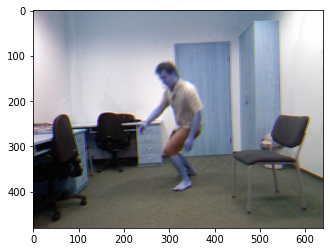

fall: 63.8%


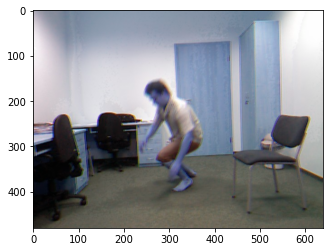

fall: 50.0%


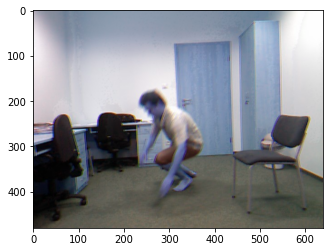

fall: 75.6%


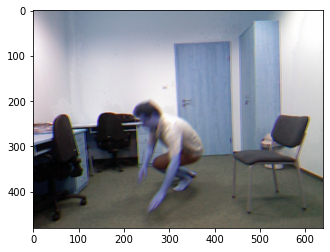

fall: 86.2%


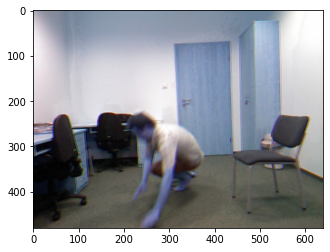

fall: 68.7%


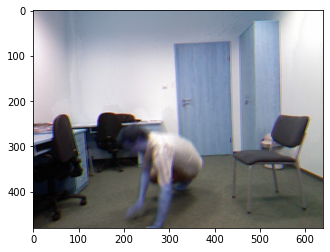

fall: 56.9%


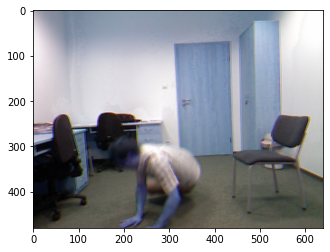

fall: 79.4%


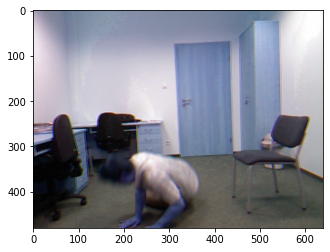

fall: 70.3%


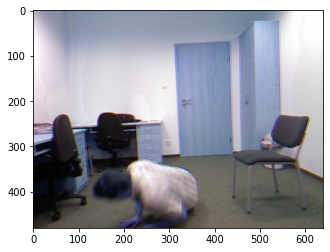

fall: 67.0%


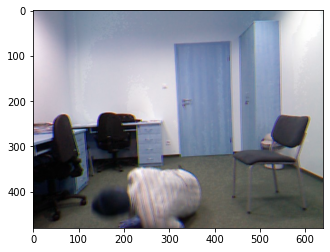

fall: 53.7%


In [ ]:
for (frame, _), prob in zip(input_batch, result):
    if prob[0] > 0.5:
        plt.imshow(frame)
        plt.show()
        print(f'fall: {prob[0]:.1%}')